In [1]:
import os
import pytesseract
from PIL import Image, ImageDraw, ImageFont
from datasets import load_dataset
from groq import Groq
from dotenv import load_dotenv
from utils import Utils

load_dotenv()

True

In [2]:
dataset = load_dataset("ayoub999/dataset_for_orange_factures")
example = dataset['test'][1]['image']

ocr_data = pytesseract.image_to_data(example, lang='fra', output_type=pytesseract.Output.DICT)

words = ocr_data['text']
boxes = [
    [
        ocr_data['left'][i],
        ocr_data['top'][i],
        ocr_data['left'][i] + ocr_data['width'][i],
        ocr_data['top'][i] + ocr_data['height'][i],
    ]
    for i in range(len(ocr_data['text']))
]

In [3]:
input_text = str(words) + "  " + "Extraire du texte précédent les informations suivante: Nom de l'entreprise, Date, ICE, Numéro de téléphone, Total à payer. Formatez votre réposne sous ce format : {'Date':'dd/mm/yyyy'; 'ICE' : 'xxxxxx'; 'Total_à_payer : 'xxxxxx'; 'Nom_de_l_entreprise' : 'xxxxxx'; 'Numéro_de_facture' : 'xxxxxx'}. Inclus cela et rien de plus. Note l'utilisation de points virgules au lieu de virgules pour separer les elements"

client = Groq(
    api_key=os.getenv("GROQ_API_KEY"),
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": input_text,
        }
    ],
    model="mixtral-8x7b-32768",
)

In [4]:
response = chat_completion.choices[0].message.content
structured_data = Utils.query_to_dict(response)
structured_data

{'Date': '29/12/2022',
 'ICE': '001537216000013',
 'Total_à_payer': '2900000',
 'Nom_de_l_entreprise': 'CUistoquipSARL',
 'Numéro_de_facture': 'FA2022-000246'}

In [5]:
data2boxes = {}
for key in structured_data:
    idx = Utils.closest_finder(structured_data[key], words)
    data2boxes[key] = boxes[idx]
data2boxes

{'Date': [294, 333, 378, 345],
 'ICE': [764, 1687, 903, 1699],
 'Total_à_payer': [994, 526, 1044, 541],
 'Nom_de_l_entreprise': [62, 49, 340, 190],
 'Numéro_de_facture': [105, 333, 224, 345]}

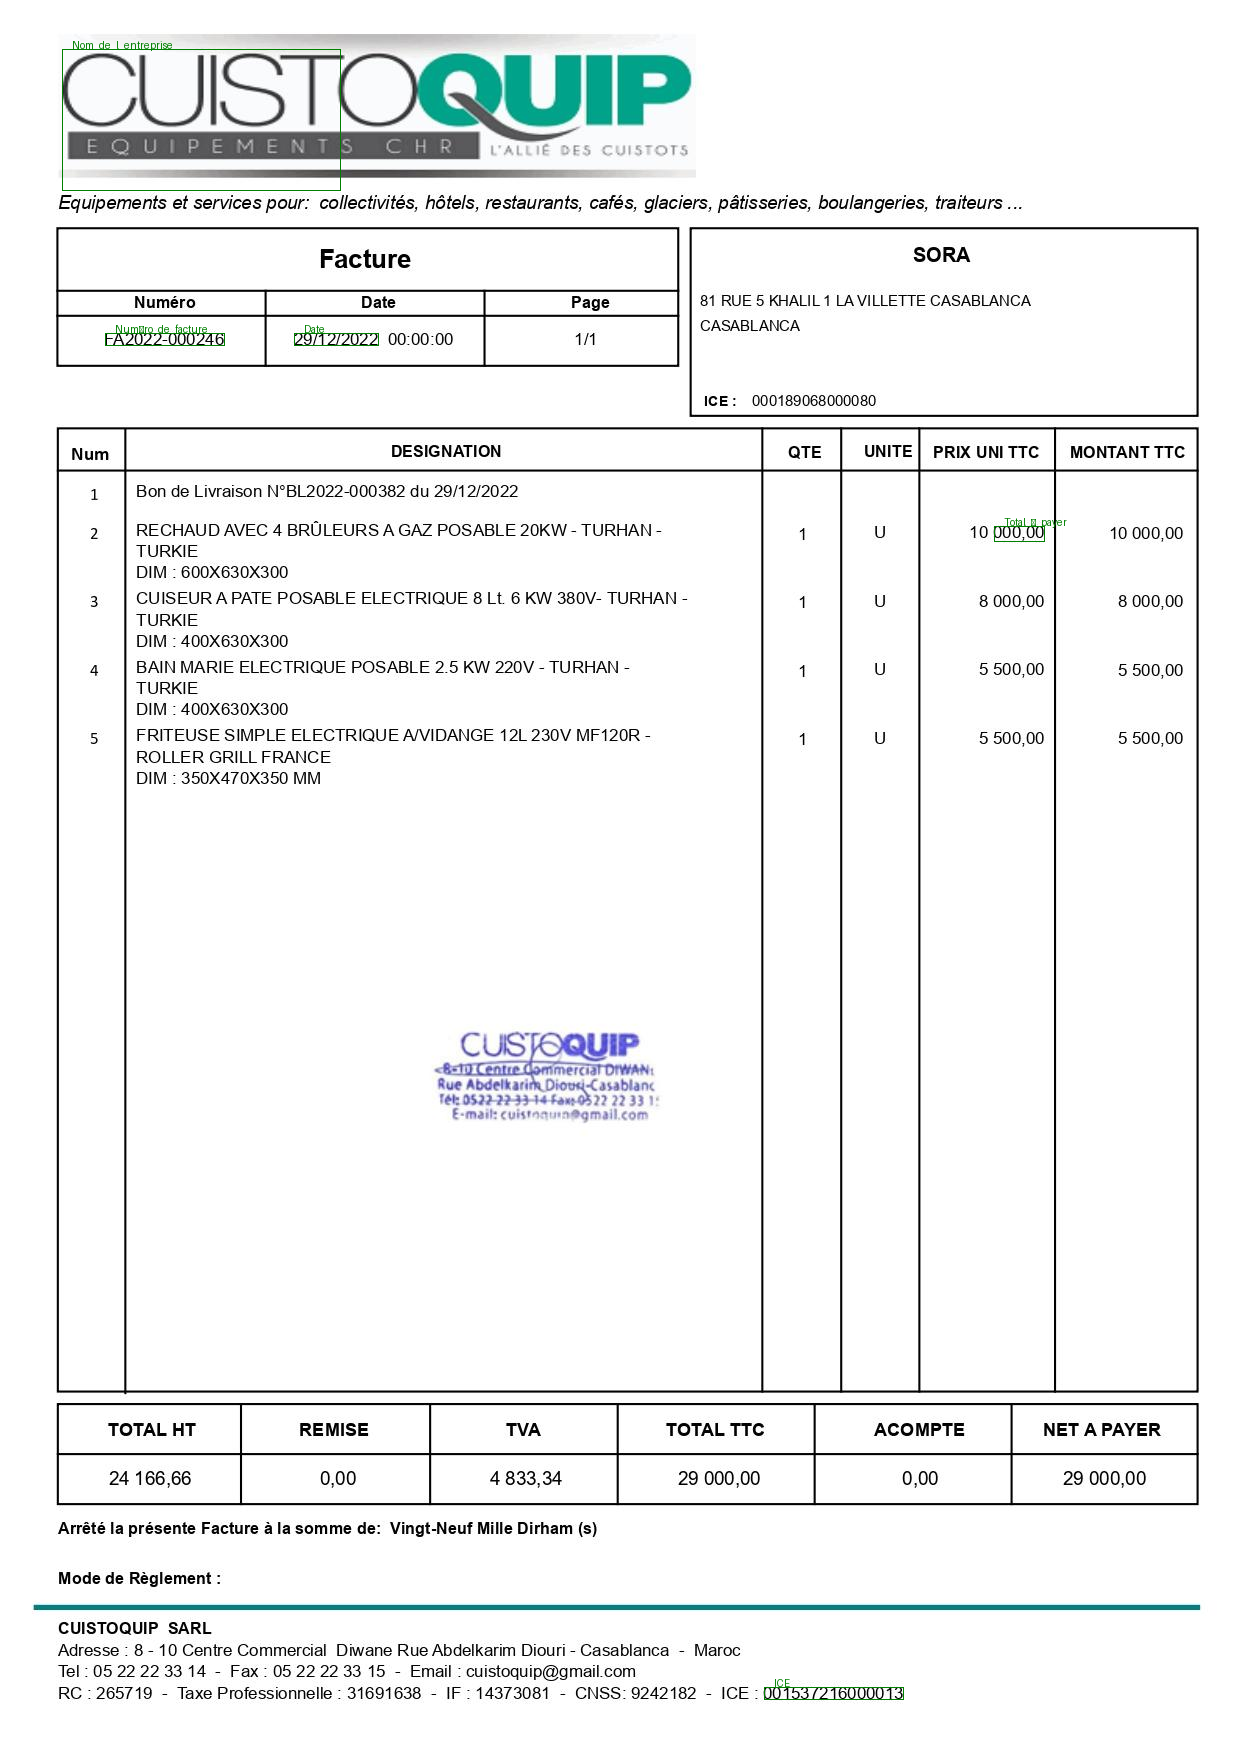

In [7]:
canvas = ImageDraw.Draw(example)
font = ImageFont.load_default()

for data in data2boxes:
    box = data2boxes[data]
    canvas.rectangle(box, outline='green')
    canvas.text((box[0] + 10, box[1] - 10), text=data, fill='green', font=font)
    
example

